# Workshop 2: Extreme Value Analysis

In this workshop, you will jump into an engineering problem to apply Extreme Value Analysis (EVA) to the design of a structure against wave loading. To do so, we will use wave data in the North sea extracted from ERA5 database. [ERA5 database](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) is based on reanalysis (a combination of model data and observations), allowing to have data for more than 60 years. 

But let's go back to our analysis. First things first, let's import the packages we will need to address this workshop. Here it is our suggestion, but feel free to add any packages you may need.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.signal import find_peaks
import datetime

The first step in the design is to determine the loading that our structure needs to withstand according to the applicable regulations and recommendations. According to them, our structure needs to be designed for a **design life of 50 years** and a **failure probability along the design life of 0.1**. 

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 1:</b>
Calculate the design return period. Round it to an integer number for the shake of simplicity.
</p>
</div>

In [2]:
# Your code here
# RT = (1) / (1-(1-p)^(1/DL))
print((1)/(1-(1-0.1)**(1/50)))

475.06125465234106


Now that we know the design return period, let's start with the analysis of our wave data. Choose one of the provided datasets and import it using the code below. Note that you will have to change the name of the file depending on the selected dataset.

In [3]:
pandas = pd.read_csv('Time_Series_DEN_lon_8_lat_56.5_ERA5.txt', delimiter=r"\s+", 
                     names=['date_&_time', 
                            'significant_wave_height_(m)', 
                            'mean_wave_period_(s)', 
                            'Peak_wave_Period_(s)', 
                            'mean_wave_direction_(deg_N)', 
                            '10_meter_wind_speed_(m/s)', 
                            'Wind_direction_(deg_N)'],  # custom header names
                     skiprows=1)  # Skip the initial row (header)
print(len(pandas))

155598


We will change the format of the time stamp and start taking looking how our data looks. Ensure you know what it is in each column of the dataframe.

In [4]:
pandas['date_&_time'] = pd.to_datetime(pandas['date_&_time']-719529, unit='D')

# The value 719529 is the datenum value of the Unix epoch start (1970-01-01), 
# which is the default origin for pd.to_datetime().

pandas.head()

,date_&_time,significant_wave_height_(m),mean_wave_period_(s),Peak_wave_Period_(s),mean_wave_direction_(deg_N),10_meter_wind_speed_(m/s),Wind_direction_(deg_N)
0,1950-01-01 00:00:00.000000000,1.274487,4.493986,5.177955,199.731575,8.582743,211.166241
1,1950-01-01 04:00:00.000026880,1.338850,4.609748,5.255064,214.679306,8.867638,226.280409
2,1950-01-01 07:59:59.999973120,1.407454,4.775651,5.390620,225.182820,9.423382,230.283209
3,1950-01-01 12:00:00.000000000,1.387721,4.800286,5.451532,227.100041,9.037646,238.879880
4,1950-01-01 16:00:00.000026880,1.660848,5.112471,5.772289,244.821975,10.187995,242.554054


<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 2:</b>
Plot the wave height time series. 
</p>
</div>

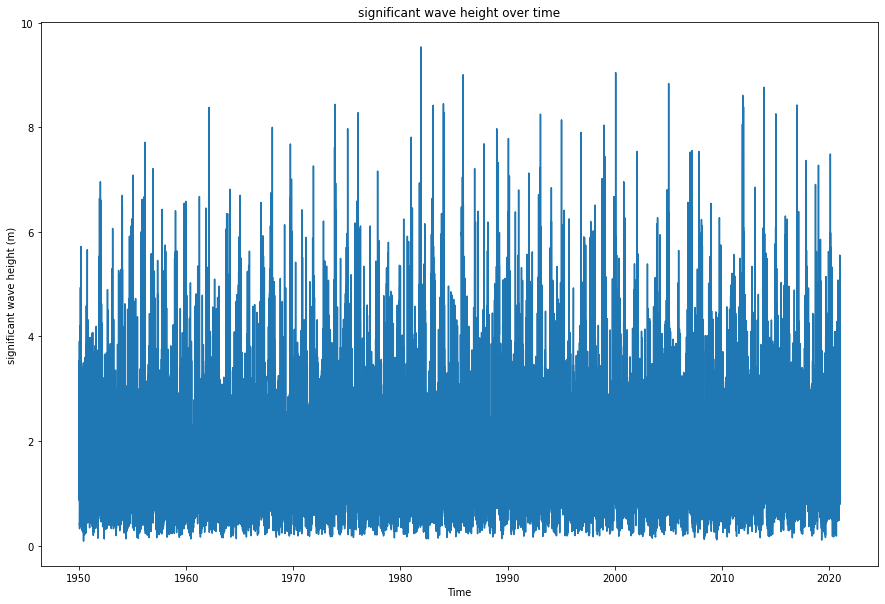

In [5]:
plt.figure(figsize = (15, 10))
plt.plot(pandas['date_&_time'], pandas['significant_wave_height_(m)'])
plt.xlabel('Time')
plt.ylabel('significant wave height (m)')
plt.title('significant wave height over time');

It is always good practice to have a look to our data, since it is the simplest way to start detecting 
possible outliers or error measurements. For instance, when working with data coming from buoys, a extremely high
or low number (such as 9999 or -9999) is recorded when the buoy is not able to measure. That way error measurements
can be easily removed before our analysis.

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 3:</b>
Calculate the basic descriptive statistics. What can you conclude from them?
</p>
</div>

In [6]:
# Your code here
pandas.describe()
#There are no real outliers in the dataset. 

,significant_wave_height_(m),mean_wave_period_(s),Peak_wave_Period_(s),mean_wave_direction_(deg_N),10_meter_wind_speed_(m/s),Wind_direction_(deg_N)
count,155598.000000,155598.000000,155598.000000,155598.000000,155598.000000,155598.000000
mean,1.590250,5.634407,6.636580,232.701281,8.319785,204.579953
std,1.025524,1.292642,2.034652,88.523561,3.449235,93.936119
min,0.085527,2.331908,1.826027,0.000001,0.337945,0.013887
25%,0.845189,4.691991,5.280570,195.018128,5.749446,125.038362
50%,1.343157,5.493290,6.347569,257.075066,8.063807,221.875462
75%,2.072028,6.442927,7.606390,303.985158,10.585083,286.772466
max,9.537492,13.610824,21.223437,359.985729,28.536715,359.997194


In the following code, we are selecting the dominant wave direction. To do so, we select the values of the wave height above the 99% percentile (we are interested in the highest values) and select the range of directions corresponding to those observations. The resulting selection is stored in a new pandas dataframe names '*pandas_angle*'. The process is illustrated in the plots.

5.003667620267622


(0.0, 350.0)

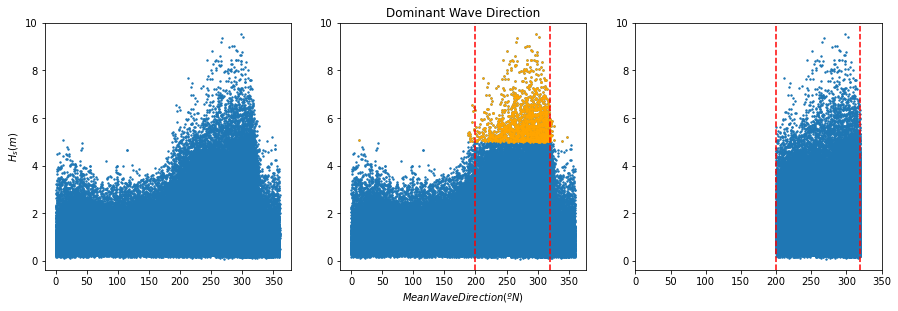

In [7]:
plt.figure(2, figsize = (15,10), facecolor='white')

plt.subplot(2,3,1)
plt.scatter(pandas['mean_wave_direction_(deg_N)'], pandas['significant_wave_height_(m)'], s = 2)
plt.ylabel('${H_s (m)}$')

print(pandas['significant_wave_height_(m)'].quantile(0.99))
pandas_99 = pandas[pandas['significant_wave_height_(m)']>=pandas['significant_wave_height_(m)'].quantile(0.99)]

plt.subplot(2,3,2)
plt.title('Dominant Wave Direction')
plt.scatter(pandas['mean_wave_direction_(deg_N)'], pandas['significant_wave_height_(m)'], s = 2)
plt.scatter(pandas_99['mean_wave_direction_(deg_N)'], pandas_99['significant_wave_height_(m)'], color='orange', s = 2)
plt.axvline(x = 200, color = 'r', linestyle = 'dashed')
plt.axvline(x = 320, color = 'r', linestyle = 'dashed')
plt.xlabel('$Mean Wave Direction (ºN)$')


pandas_angle = pandas[(pandas['mean_wave_direction_(deg_N)'].between(200, 320))]

plt.subplot(2,3,3)
plt.scatter(pandas_angle['mean_wave_direction_(deg_N)'], pandas_angle['significant_wave_height_(m)'], s = 2)
plt.axvline(x = 200, color = 'r', linestyle = 'dashed')
plt.axvline(x = 320, color = 'r', linestyle = 'dashed')
plt.xlim([0, 350])

In the following code, first, we compute the wave length and wave steepness of each observation. After that, we plot the wave height against the wave period highlighting those values of the wave height above the 99% percentile, and draw the lines of constant wave steepness (quotient between the wave height and the wave length).

<ipython-input-8-50a9c29ea0fa>:14: RuntimeWarning: divide by zero encountered in double_scalars
  L[iL,jL] =  L0[jL]*np.tanh(2*np.pi*(Depth/(L[iL-1,jL])))


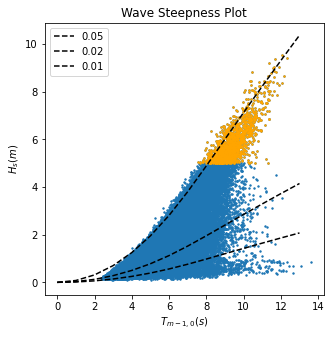

In [8]:
#Calculate theoretical wave steepness lines following the wave dispersion relationship.
N = 15
iterations = 20
Depth = 35
T_p = np.linspace(0,N,N+1)
L0 = 9.81*(T_p**2)/(2*np.pi) # Deep water wave length
L = np.zeros((iterations,len(T_p)))
L[0,:] = L0                # Initial guess for wave length = deep water wave length
L[0,0] = 0.1

# Calculate the wave periods using an iterative approach
for iL in np.arange(1,(len(L[:,0]))):
    for jL in np.arange(0,len(T_p)):
        L[iL,jL] =  L0[jL]*np.tanh(2*np.pi*(Depth/(L[iL-1,jL])))

# Compute theoretical significant wave heights for different steepnesses
Hs005 = L[-1,:]*0.05;
Hs002 = L[-1,:]*0.02;
Hs001 = L[-1,:]*0.01;

plt.figure(3, figsize = (5,5), facecolor='white')
plt.scatter(pandas['mean_wave_period_(s)'], pandas['significant_wave_height_(m)'], s = 2)
plt.scatter(pandas_99['mean_wave_period_(s)'], pandas_99['significant_wave_height_(m)'], color='orange', s = 2)
plt.plot(T_p[:-2], Hs005[:-2], linestyle = 'dashed', color = 'black', label = 0.05)
plt.plot(T_p[:-2], Hs002[:-2], linestyle = 'dashed', color = 'black', label = 0.02)
plt.plot(T_p[:-2], Hs001[:-2], linestyle = 'dashed', color = 'black', label = 0.01)
plt.xlabel('${T_{m-1,0} (s)}$')
plt.ylabel('${H_s (m)}$')
plt.title('Wave Steepness Plot')
plt.legend()

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 4:</b>
Based on the results of the two previous analysis, which data should we consider for our EVA? Why?
</p>
</div>

Your answer here

Use the dataframe '*pandas_angle*' for the following steps. 

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 5:</b>
Apply Yearly Maxima to sample the extreme observations. Plot the results.
</p>
</div>

The shape of the sampled extremes is: (71, 7)


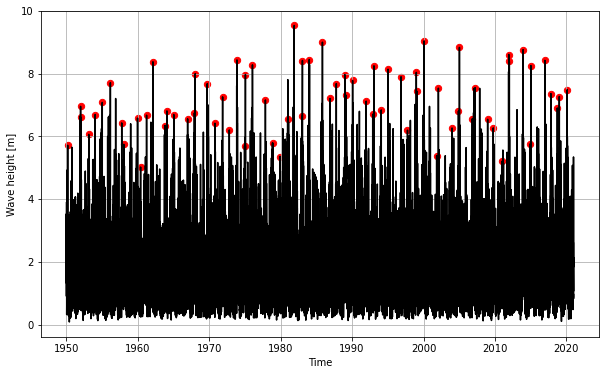

In [9]:
# Your code here
idx_max = pandas_angle.groupby(pd.DatetimeIndex(pandas_angle['date_&_time']).year)['significant_wave_height_(m)'].idxmax()
YM = pandas_angle.loc[idx_max]
print('The shape of the sampled extremes is:', YM.shape)

plt.figure(figsize=(10, 6))
plt.plot(pandas_angle['date_&_time'], pandas_angle['significant_wave_height_(m)'],'k')
plt.scatter(YM['date_&_time'], YM['significant_wave_height_(m)'], 40, 'r')
plt.xlabel('Time')
plt.ylabel('Wave height [m]')
plt.grid();

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 6:</b>
Fit the sampled extremes to fit a Generalized Extreme Value distribution.
</p>
</div>

GEV parameters are: 0.288, 6.820, 1.013


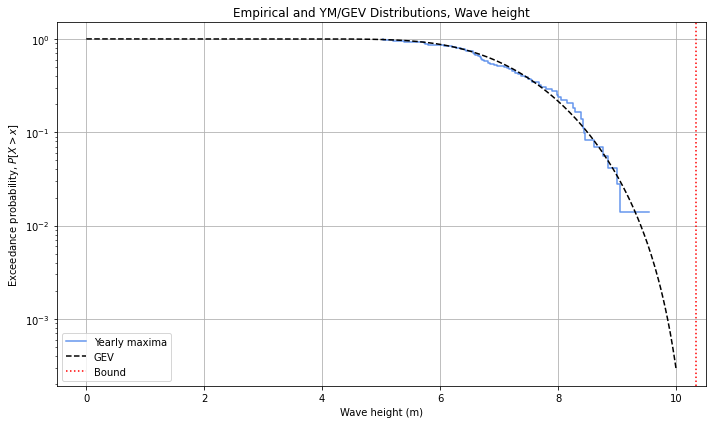

In [10]:
# Your code here
def ecdf(var):
    x = np.sort(var)
    n = x.size
    y = np.arange(1, n + 1)/(n + 1)
    return [y, x]

params_YM = stats.genextreme.fit(YM['significant_wave_height_(m)'])
print('GEV parameters are: {:.3f}, {:.3f}, {:.3f}'.format(*params_YM))

x_range = np.linspace(0, 10, 500)
plt.figure(figsize=(10, 6))
plt.step(ecdf(YM['significant_wave_height_(m)'])[1],
         1 - ecdf(YM['significant_wave_height_(m)'])[0],
         'cornflowerblue',
         label = 'Yearly maxima')
plt.plot(x_range,
         1 - stats.genextreme.cdf(x_range, *params_YM),
         '--k', label='GEV')
if params_YM[0]>0:
    bound_YM = params_YM[1] - params_YM[2]/(-params_YM[0])
    plt.axvline(x = bound_YM, color = 'red',
                linestyle = ':',
                label='Bound')
plt.xlabel('Wave height (m)')
plt.ylabel('Exceedance probability, $P[X > x]$')
plt.yscale('log') 
plt.grid()
plt.legend()
plt.title('Empirical and YM/GEV Distributions, Wave height')
plt.tight_layout();

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 7:</b>
Assess the goodness of fit of the distribution using a QQplot. Comment about the results of the fitting.
</p>
</div>

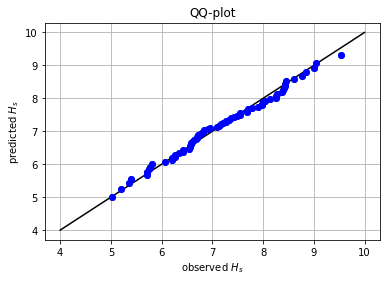

In [11]:
from scipy.stats import genextreme, norm

qq_x = ecdf(YM['significant_wave_height_(m)'])[1]
q_list = ecdf(YM['significant_wave_height_(m)'])[0]
qq_y = genextreme.ppf(q_list, *params_YM)



plt.plot([4, 10], [4, 10], 'k')
plt.scatter(qq_x, qq_y)
plt.plot(qq_x, qq_y, 'bo')
plt.xlabel('observed $H_{s}$')
plt.ylabel('predicted $H_{s}$')
plt.title('QQ-plot')
plt.grid();


Your interpretation here

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 8:</b>
Plot the return level plot and determine the value of the significant wave height that you need for design according to your calculated return period. Remember that return level plot presents in the x-axis the values of the variable (wave height, here) and in the y-axis the corresponding values of the return period. 
    
*Hint: check the definition of return period, it is very easy!*
</p>
</div>

Wave height for RT=475 years: 9.74


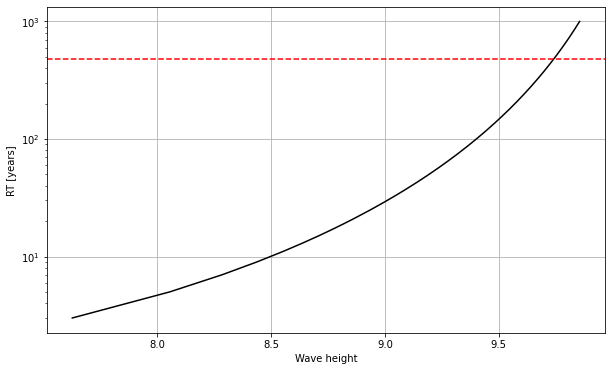

In [12]:
RT_range = np.linspace(1, 1000, 500)
yearly_probs = 1/(RT_range)
eval_waveheight = stats.genextreme.ppf(1-yearly_probs, *params_YM)

plt.figure(figsize=(10, 6))
plt.plot(eval_waveheight, RT_range, 'k')
plt.xlabel('Wave height')
plt.ylabel('RT [years]')
plt.yscale('log') 
plt.grid()
plt.axhline(475, c = 'r', ls = '--')

index = np.argmin(np.abs(RT_range - 475))
wave_height_for_475 = eval_waveheight[index]

print(f"Wave height for RT=475 years: {wave_height_for_475:.2f}")

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 9:</b>
Apply POT to sample the extreme observations. Plot the results.
    
Use a threshold of 5 meters and a declustering time of 72h.
</p>
</div>

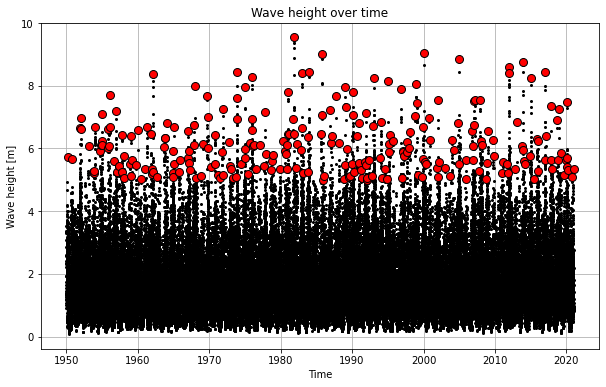

In [13]:
Hs = (pandas_angle.iloc[:, 1]).values
date = (pandas_angle.iloc[:, 0]).values

loc_excesses, _ = find_peaks(Hs, height = 5, distance = 72) 
excesses = Hs[loc_excesses] 
date = date[loc_excesses]


plt.figure(figsize=(10, 6))
plt.plot(pandas_angle['date_&_time'], pandas_angle['significant_wave_height_(m)'],'k.', markersize=4)
plt.xlabel('Time')
plt.ylabel('Wave height [m]')
plt.grid()
plt.title('Wave height over time')

plt.plot(date, excesses,'r.', markersize=16, markeredgecolor='k');


<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 10:</b>
Fit the sampled extremes to fit a Generalized Pareto distribution. Print the shape parameter. What type of GPD are you obtaining?
</p>
</div>

The shape parameter is: -0.25135287328433853, this means a upperbound at a certain waveheight


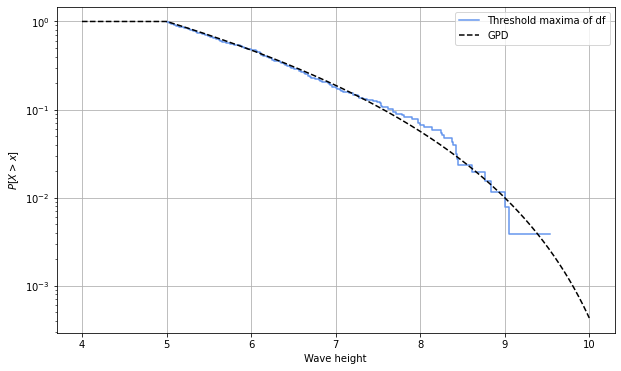

In [14]:
# Your code here
def ecdf(var):
    x = np.sort(var)
    n = x.size
    y = np.arange(1, n+1) / (n+1)
    return [y, x]

params_2 = stats.genpareto.fit(excesses-5)

x_range = np.linspace(4, 10, 1000)
plt.figure(figsize=(10, 6))
plt.step(ecdf(excesses)[1], 1-ecdf(excesses)[0],'cornflowerblue', label = 'Threshold maxima of df')
plt.plot(x_range, 1-stats.genpareto.cdf(x_range-5, *params_2),
             '--k', label='GPD')
plt.xlabel('Wave height')
plt.ylabel('${P[X > x]}$')
plt.yscale('log') 
plt.grid()
plt.legend()
print(f'The shape parameter is: {params_2[0]}, this means a upperbound at a certain waveheight');

Your interpretation here

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 11:</b>
Assess the goodness of fit of the distribution using a QQplot. Comment about the results of the fitting and compare it to those obtained using BM and GEV. Which one would you choose?
</p>
</div>

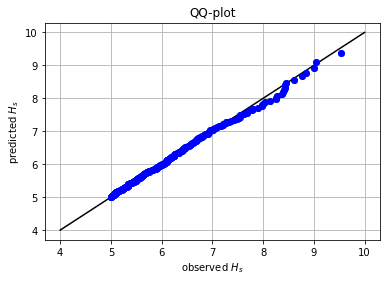

In [15]:
from scipy.stats import genpareto, expon

qq_x = ecdf(excesses)[1]
q_list = ecdf(excesses)[0]

qq_y = genpareto.ppf(q_list, *params_2)+5

plt.plot([4, 10], [4, 10], 'k')
plt.scatter(qq_x, qq_y)
plt.plot(qq_x, qq_y, 'bo')
plt.xlabel('observed $H_{s}$')
plt.ylabel('predicted $H_{s}$')
plt.title('QQ-plot')
plt.grid();



Your interpretation here

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 12:</b>
Plot the return level plot and determine the value of the significant wave height that you need for design according to your calculated return period. Remember that return level plot presents in the x-axis the values of the variable (wave height, here) and in the y-axis the corresponding values of the return period. 

Compare it to the results obtained using BM + GEV.
</p>
</div>

YM design value: 9.740401993677025
255
p: 0.000586171310629515
POT design value with ppf: 9.932294319730481


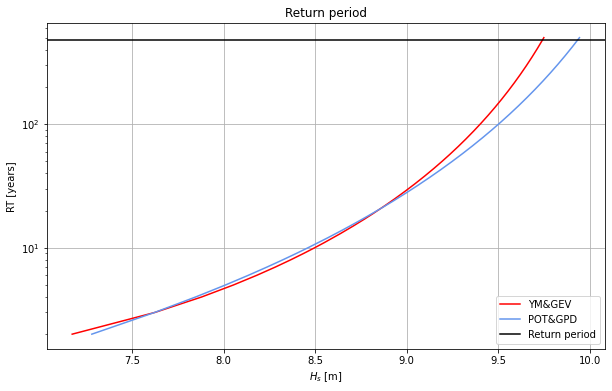

In [16]:
# Your code here
# YM & GEV
RT = 475 #years

YM_design_value = stats.genextreme.ppf(1-1/RT, *params_YM)
print('YM design value:', YM_design_value)

# POT & GPD
number_excesses = len(loc_excesses)
number_years = 2020-1950+1
print(len(loc_excesses))

average_n_excesses = number_excesses/number_years #yearly
non_exc_prob = (1-1/(RT*average_n_excesses)) 
print(f'p: {1/RT/average_n_excesses}')

POT_design_value = stats.genpareto.ppf(non_exc_prob, *params_2) +5
print('POT design value with ppf:', POT_design_value)

RT_range = np.linspace(2, 500, 500)

yearly_probs = 1/(RT_range)
YM_range = stats.genextreme.ppf(1-yearly_probs, *params_YM)
yearly_probs_corrected = yearly_probs/average_n_excesses
POT_range = stats.genpareto.ppf(1-yearly_probs_corrected, *params_2) +5

plt.figure(figsize=(10, 6))
plt.plot(YM_range, RT_range, 'r', label = 'YM&GEV')
plt.plot(POT_range, RT_range, 'cornflowerblue', label = 'POT&GPD')
plt.axhline(RT, label='Return period', color='black')
plt.xlabel('$H_{s}$ [m]')
plt.ylabel('RT [years]')
plt.title('Return period')
plt.yscale('log')
plt.legend()
plt.grid()

Your interpretation here

We have performed the analysis with a given threshold = 5m and declustering time = 72h. But are they reasonable? 

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Task 13:</b>
Apply at least one method to justify why a threshold=5m and a declustering time=72h are reasonable or not. Write your conclusions.
</p>
</div>

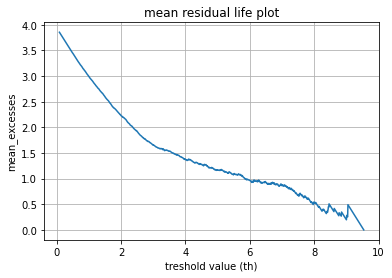

In [17]:
# Your code here
Hs = (pandas_angle.iloc[:, 1]).values
date = (pandas_angle.iloc[:, 0]).values

th = np.linspace(np.min(Hs), np.max(Hs), 1000)

mean_excesses = np.zeros(1000)

for i in range (1000):
    loc_excesses, _ = find_peaks(Hs, height = th[i], distance = 72) 
    excesses = Hs[loc_excesses] - th[i]
    mean_excesses[i] = np.mean(excesses)

plt.plot(th, mean_excesses)
plt.ylabel('mean_excesses')
plt.xlabel('treshold value (th)')
plt.title('mean residual life plot')
plt.grid()

Your interpretation here

End of notebook.